In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, ElasticNet
import statsmodels.api as sm
import statsmodels.formula.api as smf
#from statsmodels.stats.outliers_influence import variance_inflation_factor
#import requests
import json
import time
from Ames_Functions import *
import pickle
pd.set_option("display.max_columns", None)

In [116]:
df_house2021 = pd.read_csv("df_RE_latlongs_v2_2021.csv", index_col = 0).set_index("SaleID")
df_house2019 = load_state_pkl()["df_RE_latlong2019"][0].set_index("SaleID")
df_biz = pd.read_csv("df_EssentialLatLong_v2.csv")
#df_min_distances = pd.read_csv("df_min_distances.csv", index_col = 0)
df_driv_time_final2019 = load_state_pkl()["2019dfs_for_feature_engineering"][0].filter(regex = "_time")

In [ ]:
# df_cross = df_house.join(df_biz, how = "cross", lsuffix = "_house", rsuffix = "_biz")
# df_cross

In [98]:
# df_cross["dist"] = df_cross.apply(lambda x: get_dist(np.array([x.Lat_house, x.Long_house]), np.array([x.Lat_biz, x.Long_biz])), axis = 1)
# #df_cross.to_csv("df_cross.csv")

## Finding differences in two different variables for feature engineering
## (SKIP)

In [439]:
# (df_driv_final["from_time"]
#     .eval("HS_Lib_diff = abs(High_School - Library)")
#     .eval("SV_Rest_diff = abs(Sports_Venue - Restaurant)")
#     .eval("Mov_Rest_diff = abs(Movies-Restaurant)")
#     .eval("Park_Rec_diff = abs(Park - Recreation)")
#     .eval("Groc_Shop_diff = abs(Organic_Groceries - Shopping)")
# ).filter(regex = "diff$").corr()
# #Possible ratios to consider:
# #High_School/Library
# #Sports_Venue/Restaurant
# #Movies/Restaurant
# #Park/Recreation
# #Organic_Groceries/Shopping
# #ISU/Library

,HS_Lib_diff,SV_Rest_diff,Mov_Rest_diff,Park_Rec_diff,Groc_Shop_diff
HS_Lib_diff,1.000000,-0.727417,-0.547363,-0.152308,-0.219560
SV_Rest_diff,-0.727417,1.000000,0.848838,-0.122952,0.397418
Mov_Rest_diff,-0.547363,0.848838,1.000000,-0.274410,0.370700
Park_Rec_diff,-0.152308,-0.122952,-0.274410,1.000000,-0.468057
Groc_Shop_diff,-0.219560,0.397418,0.370700,-0.468057,1.000000


## Finding ratios of distances from two different services for feature engineering 
## (SKIP)

In [652]:
#Possible ratios to consider:
#High_School/Library
#Sports_Venue/Restaurant
#Movies/Restaurant
#Park/Recreation
#Organic_Groceries/Shopping
#ISU/Library

ratio_dict = {}

for a, b in [("High_School", "Library"), ("Sports_Venue", "Restaurant"), ("Movies", "Restaurant"), ("Park", "Recreation"), ("Organic_Groceries", "Shopping"), ("ISU", "Library")]:
      ratio_dict[f"{a}_{b}_ratio"] = (df_driv_final["from_time"]
                                                .apply(lambda x: x[a]/x[b] if x[a] > x[b] else x[b]/x[a], axis = 1)
                                                .rename(f"{a}_{b}_ratio")
                                    )

pd.DataFrame(ratio_dict).join(df_driv_final["from_time"].SalePrice)

,High_School_Library_ratio,Sports_Venue_Restaurant_ratio,Movies_Restaurant_ratio,Park_Recreation_ratio,Organic_Groceries_Shopping_ratio,ISU_Library_ratio,SalePrice
SaleID,,,,,,,
2,1.201318,2.804738,2.791816,1.018666,1.573722,1.159183,78000.0
3,1.201318,2.804738,2.791816,1.018666,1.573722,1.159183,408905.0
18,1.197453,2.743412,2.730929,1.018309,1.553475,1.156232,434066.0
19,1.196223,2.724280,2.711934,1.018196,1.547170,1.155292,88000.0
20,1.194971,2.704985,2.692777,1.018080,1.540816,1.154335,88000.0
...,...,...,...,...,...,...,...
22743,1.736798,1.551261,1.102166,1.041003,1.440054,1.712640,220000.0
22749,1.682007,1.504043,1.092605,1.038153,1.401589,1.659646,217500.0
22756,1.650223,1.477176,1.087238,1.036486,1.379769,1.628904,229000.0


In [ ]:
EDA_report(pd.DataFrame(ratio_dict).drop(["Sports_Venue_Restaurant_ratio", "ISU_Library_ratio"], axis = 1).join(df_driv_final["from_time"].SalePrice))

In [665]:
get_vif(pd.DataFrame(ratio_dict).drop(["Sports_Venue_Restaurant_ratio", "ISU_Library_ratio"], axis = 1))

[2.6474191730790873,
 2.0026501116710853,
 2.9995764720823432,
 1.1216954870182765]

## Lasso feature selection section using lassoCV

### 2021 section

In [ ]:
#checking VIF for all df_driv_final variables
get_vif(df_driv_final["from_time"].iloc[:, :-1])

In [398]:
X_lassoCV = {}
y_lassoCV = {}
X_lassoCV["from_time"] = df_driv_final["from_time"].drop("SalePrice", axis = 1)
y_lassoCV["from_time"] = df_driv_final["from_time"].SalePrice

In [ ]:
lassoCV = LassoCV(normalize = True)
lassoCV.fit(X_lassoCV["from_time"], y_lassoCV["from_time"])
lassoCV.feature_names_in_[np.where(lassoCV.coef_ != 0)]

In [ ]:
#checking VIF for only the lassoCV selected features in df_driv_final
lassoCV_coefs = {}

lassoCV_coefs["from_time"] = df_driv_final["from_time"][lassoCV.feature_names_in_[np.where(lassoCV.coef_ != 0)]]
lassoCV_coefs["from_time"].corr()

#get_vif(lassoCV_coefs["from_time"])

,Lat_house,Movies,Park,Recreation,Spa
Lat_house,1.000000,0.574386,0.114682,0.045949,-0.037722
Movies,0.574386,1.000000,0.563701,0.699062,0.537828
Park,0.114682,0.563701,1.000000,0.541209,0.569881
Recreation,0.045949,0.699062,0.541209,1.000000,0.930184
Spa,-0.037722,0.537828,0.569881,0.930184,1.000000


### 2019 section

In [13]:
#checking VIF for all df_driv_final variables
get_vif(df_driv_time_final2019.iloc[:, 2:-1])

[497.8720803675777,
 166.25262248853497,
 105.49663127559329,
 47.42152644218676,
 165.93510868566523,
 736.8679303864168,
 541.2549557538485,
 474.8168538915485,
 775.8228970286154,
 567.6047378056903,
 74.83131469946107,
 133.6042345276011,
 163.16991644494607,
 47.907261158854055,
 171.76357040297557,
 432.41773327566807,
 243.22226438952976,
 1123.4555166356288]

In [15]:
X_lassoCV = {}
y_lassoCV = {}
X_lassoCV["from_time"] = df_driv_time_final2019.drop("SalePrice", axis = 1)
y_lassoCV["from_time"] = df_driv_time_final2019.SalePrice

In [16]:
lassoCV = LassoCV(normalize = True)
lassoCV.fit(X_lassoCV["from_time"], y_lassoCV["from_time"])
lassoCV.feature_names_in_[np.where(lassoCV.coef_ != 0)]

/Users/lelandmurrin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


array(['Golf', 'Library', 'Movies', 'Recreation', 'Religion'],
      dtype=object)

In [17]:
#checking VIF for only the lassoCV selected features in df_driv_final
lassoCV_coefs = {}

lassoCV_coefs["from_time"] = df_driv_time_final2019[lassoCV.feature_names_in_[np.where(lassoCV.coef_ != 0)]]
lassoCV_coefs["from_time"].corr()

#get_vif(lassoCV_coefs["from_time"])

,Golf,Library,Movies,Recreation,Religion
Golf,1.000000,0.233646,0.275352,0.433672,0.505963
Library,0.233646,1.000000,0.791193,0.841805,0.652546
Movies,0.275352,0.791193,1.000000,0.679968,0.396524
Recreation,0.433672,0.841805,0.679968,1.000000,0.747969
Religion,0.505963,0.652546,0.396524,0.747969,1.000000


## Find Homes that had all businesses nearby vs all homes that had businesses far away
## (SKIP)

In [522]:
#TODO: ADD THIS TO A VISUAL ON AMES MAP

#mean_shop = np.mean(df_driv_final["from_time"][["Shopping"]])[0]
df_nearby = (df_driv_final["from_time"]
    .drop(["Lat_house", "Long_house", "SalePrice"], axis = 1)[df_driv_final["from_time"].drop(["Lat_house", "Long_house", "SalePrice"], axis = 1).transform(lambda x: x < x.mean())]
    .dropna()
    #.isnull()
    #.sum(axis = 0)
    #.sort_values(ascending = False)
) #.plot.hist(alpha = 0.3) #.corr()

df_far = (df_driv_final["from_time"]
    .drop(["Lat_house", "Long_house", "SalePrice"], axis = 1)[df_driv_final["from_time"].drop(["Lat_house", "Long_house", "SalePrice"], axis = 1).transform(lambda x: x > x.mean())]
    .dropna()
    #.isnull()
    #.sum(axis = 0)
    #.sort_values(ascending = False)
) #.plot.hist(alpha = 0.3) #.corr()
df_far.corr().Library #Library, Elem, 

Arts                 1.000000
Elem_School         -0.072957
Golf                -0.072957
Gym                  0.996288
High_School         -0.072957
Historic             0.212780
ISU                  0.324654
Library              1.000000
Medical             -0.000541
Movies               0.996659
Organic_Groceries   -0.072957
Park                 0.996659
Recreation           0.998420
Religion             1.000000
Restaurant          -0.072957
Shopping            -0.072957
Spa                  1.000000
Sports_Venue         0.996659
Name: Library, dtype: float64

In [525]:
get_vif(df_far[["Library", "Historic"]])

[94.77171340563096, 94.77171340563096]

## Creating feature for average distance of closest 5 services to each house record

### 2021 Section

In [613]:
df_closest = {}

for i in [1, 5, 10, 15]:
    df_closest[f"Closest_{i}"] = (df_driv_final["from_time"]
        .drop(["Lat_house", "Long_house", "SalePrice"], axis = 1)
        .stack()
        .reset_index()
        .set_axis(["SaleID", "Service", "driv_time"], axis = 1)
        .sort_values("driv_time")
        .groupby("SaleID")
        .head(i)
        .sort_values(["SaleID", "driv_time"])
        .groupby("SaleID")
        .driv_time
        .mean()
        #[["driv_time"]]
        #.mean().driv_time
    )

pd.DataFrame(df_closest)#.join(df_driv_final["from_time"].SalePrice)

,Closest_1,Closest_5,Closest_10,Closest_15
SaleID,,,,
2,85.5,210.28,324.33,403.220000
3,85.5,210.28,324.33,403.220000
18,95.3,220.08,334.13,413.020000
19,98.5,223.28,337.33,416.220000
20,101.8,226.58,340.63,419.520000
...,...,...,...,...
22743,276.6,295.28,333.13,363.680000
22749,305.2,323.88,361.73,392.280000
22756,324.0,342.68,380.53,411.080000


In [877]:
selected_features_dict = {}
selected_features_dict["Closest_5_feature"] = df_closest['Closest_5']

In [ ]:
#Checking EDA report for each closest 1,5,10,15 businesses to a home
for i in [1,5,10,15]:
    EDA_report(pd.DataFrame(df_closest)[[f"Closest_{i}"]].join(df_driv_final["from_time"].SalePrice))

### 2019 Section

In [24]:
df_closest = {}

for i in [1, 5, 10, 15]:
    df_closest[f"Closest_{i}"] = (df_driv_time_final2019
        .drop(["Lat_house", "Long_house", "SalePrice"], axis = 1)
        .stack()
        .reset_index()
        .set_axis(["SaleID", "Service", "driv_time"], axis = 1)
        .sort_values("driv_time")
        .groupby("SaleID")
        .head(i)
        .sort_values(["SaleID", "driv_time"])
        .groupby("SaleID")
        .driv_time
        .mean()
        #[["driv_time"]]
        #.mean().driv_time
    )

pd.DataFrame(df_closest).sort_values("Closest_1")#.join(df_driv_final["from_time"].SalePrice)

,Closest_1,Closest_5,Closest_10,Closest_15
SaleID,,,,
1419,6.3,130.28,187.84,228.200000
12929,7.8,339.40,404.03,450.320000
8324,8.4,55.84,80.44,136.620000
12927,8.4,339.52,404.03,450.200000
8342,12.8,57.86,79.48,136.573333
...,...,...,...,...
3906,371.0,455.70,501.02,547.180000
3867,371.1,455.80,501.12,547.280000
3920,378.0,462.70,508.02,554.180000


In [ ]:
selected_features_dict = {}
selected_features_dict["Closest_5_feature"] = df_closest['Closest_5']

In [ ]:
#Checking EDA report for each closest 1,5,10,15 businesses to a home
for i in [1,5,10,15]:
    EDA_report(pd.DataFrame(df_closest)[[f"Closest_{i}"]].join(df_driv_time_final2019.SalePrice))

In [117]:
df_driv_time_final2019

,Arts_time,Elem_School_time,Golf_time,Gym_time,High_School_time,Historic_time,ISU_time,Library_time,Medical_time,Movies_time,Organic_Groceries_time,Park_time,Recreation_time,Religion_time,Restaurant_time,Shopping_time,Spa_time,Sports_Venue_time
SaleID,,,,,,,,,,,,,,,,,,
92,642.8,496.8,396.8,498.0,654.6,626.9,753.3,630.3,585.7,798.3,352.7,346.0,484.2,370.8,488.4,442.1,451.0,902.9
93,642.8,496.8,396.8,498.0,654.6,626.9,753.3,630.3,585.7,798.3,352.7,346.0,484.2,370.8,488.4,442.1,451.0,902.9
96,539.9,397.6,427.7,528.9,551.7,524.0,684.9,527.4,482.8,695.4,383.6,243.1,381.3,401.7,519.3,339.2,348.1,800.0
98,541.1,398.8,428.9,530.1,552.9,525.2,686.1,528.6,484.0,696.6,384.8,244.3,382.5,402.9,520.5,340.4,349.3,801.2
100,553.6,411.3,441.4,542.6,565.4,537.7,698.6,541.1,496.5,709.1,397.3,256.8,395.0,415.4,533.0,352.9,361.8,813.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22745,365.8,292.4,334.7,419.2,634.1,407.2,625.5,371.8,390.4,292.8,445.8,414.4,398.7,575.2,321.1,314.4,434.1,489.4
22747,366.8,293.4,335.7,420.2,635.1,408.2,626.5,372.8,391.4,293.8,446.8,415.4,399.7,576.2,322.1,315.4,435.1,490.4
22750,379.7,306.3,348.6,433.1,648.0,421.1,639.4,385.7,404.3,306.7,459.7,428.3,412.6,589.1,335.0,328.3,448.0,503.3


In [148]:
pd.DataFrame(df_closest).Closest_5

SaleID
92       381.68
93       381.68
96       339.06
98       340.26
100      352.76
          ...  
22745    311.08
22747    312.08
22750    324.98
22755    341.58
22797     99.20
Name: Closest_5, Length: 901, dtype: float64

In [150]:
def append_closest (df_input, df_times, s_closest_num):
    df = df_input.copy()
    df_temp = df_times.stack().reset_index().set_axis(["SaleID", "Service", "Closest_Time"], axis = 1).assign(Service = lambda x: x.Service.str.replace("_time", "_closest"))

    df = (df.join(pd.get_dummies(
                            df_temp.loc[df_temp.groupby("SaleID").Closest_Time.idxmin()],
                            columns = ["Service"]
                            )
                    .set_index("SaleID")
                )
            .join(s_closest_num)
        )
    return df

#EDA_report(pd.get_dummies(df_temp.drop("SalePrice", axis = 1), columns = ["Service"]).join(df_temp.pop("SalePrice")))

## Convenience Measurement Section (average proximity, measured in seconds, to all services)

### 2021 Section

In [166]:
# s_convenience2021 = (df_driv_final["from_time"]
#         .drop(["Lat_house", "Long_house", "SalePrice"], axis = 1)
#         .stack()
#         .reset_index()
#         .set_axis(["SaleID", "Service", "driv_time"], axis = 1)
#         .sort_values("driv_time")
#         .groupby("SaleID")
#         .driv_time
#         .mean()
#         .sort_values()
#         .rename("Convenience_secs")
#         # .groupby("SaleID")
#         # .driv_time
#         # .mean()
#     )

# pd.DataFrame(s_convenience2021).join(df_house2021.SalePrice)

NameError: name 'df_driv_final' is not defined

In [ ]:
EDA_report(pd.DataFrame(s_convenience2021).join(pd.DataFrame(df_closest)).join(df_driv_final["from_time"].SalePrice))

In [890]:
get_vif(pd.DataFrame(df_central).join(pd.DataFrame(df_closest["Closest_1"].rename("Closest_1"))))

[7.650401862528, 7.650401862528]

In [899]:
# selected_features_dict["Closest_all_feature"] = s_convenience2021
# selected_features_dict

{'Closest_5_feature': SaleID
 2        210.28
 3        210.28
 18       220.08
 19       223.28
 20       226.58
           ...  
 22743    295.28
 22749    323.88
 22756    342.68
 22768    343.58
 22888    309.58
 Name: driv_time, Length: 633, dtype: float64,
 'Closest_all_feature': SaleID
 9379     134.555556
 8302     137.072222
 9371     139.594444
 8227     143.994444
 9382     144.144444
             ...    
 11354    618.622222
 11336    620.538889
 11334    621.338889
 11331    621.938889
 11368    640.238889
 Name: Closest_all, Length: 633, dtype: float64}

### 2019 Section

In [ ]:
# s_convenience2019 = (df_driv_time_final2019
#         #.drop(["Lat_house", "Long_house", "SalePrice"], axis = 1)
#         .stack()
#         .reset_index()
#         .set_axis(["SaleID", "Service", "driv_time"], axis = 1)
#         .sort_values("driv_time")
#         .groupby("SaleID")
#         .driv_time
#         .mean()
#         .sort_values()
#         .rename("Convenience_secs")
#         # .groupby("SaleID")
#         # .driv_time
#         # .mean()
#     )

# pd.DataFrame(s_convenience2019).join(df_house2019.SalePrice)

In [ ]:
EDA_report(pd.DataFrame(s_convenience2019).join(pd.DataFrame(df_closest)).join(df_house2019.SalePrice))

In [ ]:
get_vif(pd.DataFrame(s_convenience2019).join(pd.DataFrame(df_closest["Closest_1"].rename("Closest_1"))))

In [ ]:
# selected_features_dict["Closest_all_feature"] = s_convenience2019
# selected_features_dict

In [ ]:
#Looking at which services are on average farthest away from all houses
#TODO: map this out
df_driv_time_final2019.iloc[:,2:-1].mean(axis = 0).sort_values(ascending = False)

In [188]:
def add_convenience_series (df_input, df_driv_time_final):
    df = df_input.copy()
    s_convenience = (df_driv_time_final
        #.drop(["Lat_house", "Long_house", "SalePrice"], axis = 1)
        .stack()
        .reset_index()
        .set_axis(["SaleID", "Service", "driv_time"], axis = 1)
        .sort_values("driv_time")
        .groupby("SaleID")
        .driv_time
        .mean()
        .sort_values()
        .rename("Convenience_secs")
        .apply(round, ndigits = 1)
        # .groupby("SaleID")
        # .driv_time
        # .mean()
    )
    return df.join(s_convenience)

## Centrality Measurement Section (Proximity to Historic Service which contains City Hall and Old Town Historic District)

In [910]:
selected_features_dict["Central_historic_feature"] = df_driv_final["from_time"].Historic

dict_keys(['Closest_5_feature', 'Closest_all_feature', 'Central_historic_feature'])

In [176]:
df_driv_time_final2019.Historic_time

SaleID
92       626.9
93       626.9
96       524.0
98       525.2
100      537.7
         ...  
22745    407.2
22747    408.2
22750    421.1
22755    437.7
22797    135.6
Name: Historic_time, Length: 901, dtype: float64

In [177]:
def add_centrality_series (df_input, df_driv_time_final):
    df = df_input.copy()
    s_centrality = df_driv_time_final.Historic_time.rename("Central_historic_feature")

    return df.join(s_centrality)

## Count Number of Businesses within 1 minute of each house section

### 2021 Section

In [913]:
num_biz_dict = {}

for i in np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])*60:
    num_biz_dict[f"biz_{i}_secs"] = (df_driv_final["from_time"]
        .drop(["Lat_house", "Long_house", "SalePrice"], axis = 1)
        .stack()
        .reset_index()
        .set_axis(["SaleID", "Service", "driv_time"], axis = 1)
        .groupby("SaleID")
        .driv_time
        .apply(lambda x: (x <= i).sum())
        .rename("count")
        #.where(lambda x: x <= i)
        # .query(f"driv_time <= {i}")
        # .SaleID
        # .value_counts()
        #.sort_values("driv_time")
        #.filter(lambda x: x.driv_time <= i)
        # .head(i)
        # .sort_values(["SaleID", "driv_time"])
        # .groupby("SaleID")
        # .driv_time
        # .mean()
    )

pd.DataFrame(num_biz_dict).join(df_driv_final["from_time"].SalePrice)

,biz_60_secs,biz_120_secs,biz_180_secs,biz_240_secs,biz_300_secs,biz_360_secs,biz_420_secs,biz_480_secs,biz_540_secs,biz_600_secs,SalePrice
SaleID,,,,,,,,,,,
2,0,1,2,2,5,6,6,8,12,13,78000.0
3,0,1,2,2,5,6,6,8,12,13,408905.0
18,0,1,2,2,5,6,6,8,12,13,434066.0
19,0,1,2,2,4,6,6,8,12,13,88000.0
20,0,1,2,2,4,6,6,8,12,13,88000.0
...,...,...,...,...,...,...,...,...,...,...,...
22743,0,0,0,0,3,7,13,15,15,16,220000.0
22749,0,0,0,0,0,5,10,14,15,16,217500.0
22756,0,0,0,0,0,4,7,14,15,15,229000.0


In [ ]:
EDA_report(pd.DataFrame(num_biz_dict).join(df_driv_final["from_time"].SalePrice))

In [ ]:
pd.DataFrame(num_biz_dict).biz_480_secs.plot.hist()

In [920]:
get_vif(pd.DataFrame(num_biz_dict)[["biz_180_secs", "biz_480_secs"]])

[2.6345201515612775, 2.6345201515612775]

In [935]:
selected_features_dict["num_biz_180s_feature"], selected_features_dict["num_biz_480s_feature"] = num_biz_dict["biz_180_secs"], num_biz_dict["biz_480_secs"]
selected_features_dict.keys()

dict_keys(['Closest_5_feature', 'Closest_all_feature', 'Central_historic_feature', 'num_biz_180s_feature', 'num_biz_480s_feature'])

In [740]:
#mean driving time in minutes for all businesses
df_driv_final["from_time"].drop(["Lat_house", "Long_house", "SalePrice"], axis = 1).describe().T['mean'].mean()/60

5.944335030132818

In [937]:
pickle.dump(selected_features_dict, open("selected_features_dict.pkl", 'wb'))

### 2019 Section

In [56]:
num_biz_dict = {}

for i in np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])*60:
    num_biz_dict[f"biz_{i}_secs"] = (df_driv_time_final2019
        .drop(["Lat_house", "Long_house", "SalePrice"], axis = 1)
        .stack()
        .reset_index()
        .set_axis(["SaleID", "Service", "driv_time"], axis = 1)
        .groupby("SaleID")
        .driv_time
        .apply(lambda x: (x <= i).sum())
        .rename("count")
        #.where(lambda x: x <= i)
        # .query(f"driv_time <= {i}")
        # .SaleID
        # .value_counts()
        #.sort_values("driv_time")
        #.filter(lambda x: x.driv_time <= i)
        # .head(i)
        # .sort_values(["SaleID", "driv_time"])
        # .groupby("SaleID")
        # .driv_time
        # .mean()
    )

pd.DataFrame(num_biz_dict).join(df_driv_time_final2019.SalePrice)

,biz_60_secs,biz_120_secs,biz_180_secs,biz_240_secs,biz_300_secs,biz_360_secs,biz_420_secs,biz_480_secs,biz_540_secs,biz_600_secs,SalePrice
SaleID,,,,,,,,,,,
92,0,0,0,0,0,2,4,6,10,11,125000.0
93,0,0,0,0,0,2,4,6,10,11,100000.0
96,0,0,0,0,1,3,7,8,14,15,399000.0
98,0,0,0,0,1,3,7,8,13,15,36000.0
100,0,0,0,0,1,2,7,8,11,15,36000.0
...,...,...,...,...,...,...,...,...,...,...,...
22745,0,0,0,0,2,5,12,14,15,16,175000.0
22747,0,0,0,0,2,5,11,14,15,16,137500.0
22750,0,0,0,0,0,5,9,14,15,16,200000.0


In [ ]:
EDA_report(pd.DataFrame(num_biz_dict).join(df_driv_time_final2019.SalePrice))

<AxesSubplot:ylabel='Frequency'>

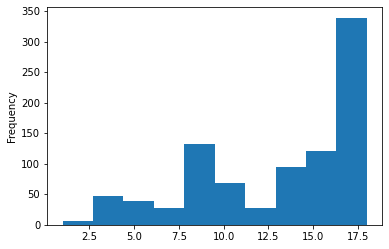

In [191]:
pd.DataFrame(num_biz_dict).biz_480_secs.plot.hist()

In [63]:
get_vif(pd.DataFrame(num_biz_dict)[["biz_180_secs", "biz_480_secs"]])

[2.493339804500264, 2.493339804500263]

In [ ]:
selected_features_dict["num_biz_180s_feature"], selected_features_dict["num_biz_480s_feature"] = num_biz_dict["biz_180_secs"], num_biz_dict["biz_480_secs"]
selected_features_dict.keys()

dict_keys(['Closest_5_feature', 'Closest_all_feature', 'Central_historic_feature', 'num_biz_180s_feature', 'num_biz_480s_feature'])

In [ ]:
#mean driving time in minutes for all businesses
df_driv_final["from_time"].drop(["Lat_house", "Long_house", "SalePrice"], axis = 1).describe().T['mean'].mean()/60

5.944335030132818

In [196]:

def add_num_biz_by_time (df_input, df_driv_time_final, times):
        df = df_input.copy()
        for t in times: 
                num_biz = (df_driv_time_final2019
                #.drop(["Lat_house", "Long_house", "SalePrice"], axis = 1)
                .stack()
                .reset_index()
                .set_axis(["SaleID", "Service", "driv_time"], axis = 1)
                .groupby("SaleID")
                .driv_time
                .apply(lambda x: (x <= t).sum())
                .rename(f"biz_{t}_secs")
                )
                df = df.join(num_biz)
        return df

## Count the number of houses around each service

In [826]:
num_house_dict = {}

for s in np.array([2, 3, 4])*60:
    num_house_dict[f"house_{s}_secs"] = (df_driv_final["from_time"]
        .drop(["Lat_house", "Long_house", "SalePrice"], axis = 1)
        .stack()
        .reset_index()
        .set_axis(["SaleID", "Service", "driv_time_secs"], axis = 1)
        .groupby('Service')
        .apply(lambda x: x[x.driv_time_secs < s].driv_time_secs.count())
    )

pd.DataFrame(num_house_dict).join(df_biz.Service.value_counts().rename("Service_count")).apply(lambda x: round(x/x.Service_count, 2), axis = 1).drop("Service_count", axis = 1)

,house_120_secs,house_180_secs,house_240_secs
Service,,,
Arts,17.67,43.00,64.33
Elem_School,23.50,49.50,111.00
Golf,1.33,16.33,33.00
Gym,27.25,52.75,81.00
High_School,2.00,28.00,110.00
Historic,29.00,58.00,80.50
ISU,0.00,3.00,64.00
Library,38.00,81.00,114.00
Medical,74.00,129.00,175.00


In [813]:
mean_SalePrice = {}

for s in np.array([2, 3, 4])*60:
    mean_SalePrice[f"mean_salePrice_{s}_secs"] = (df_driv_final["from_time"]
        .drop(["Lat_house", "Long_house"], axis = 1)
        .set_index("SalePrice")
        .stack()
        .reset_index()
        .set_axis(["SalePrice", "Service", "driv_time_secs"], axis = 1)
        .groupby('Service')
        .apply(lambda x: x[x.driv_time_secs < s].SalePrice.mean())
        .transform(round, ndigits = 2)
    )

pd.DataFrame(mean_SalePrice).sort_values(by = "mean_salePrice_120_secs")

,mean_salePrice_120_secs,mean_salePrice_180_secs,mean_salePrice_240_secs
Service,,,
High_School,147375.00,213282.14,206375.00
Historic,166041.12,184953.67,196863.83
Medical,178680.08,186369.58,200287.29
Recreation,184346.26,188721.04,202233.86
Spa,191721.71,208934.29,212455.78
Organic_Groceries,202259.42,212034.15,240566.40
Shopping,204111.48,200157.49,208839.61
Library,215477.43,204664.55,207509.27
Arts,218552.83,202680.42,213048.71


In [832]:
df_nearby_houses = (pd.DataFrame(mean_SalePrice)
    .join(pd.DataFrame(num_house_dict)
          .join(df_biz.Service.value_counts().rename("Service_count"))
          .apply(lambda x: round(x/x.Service_count, 2), axis = 1)
          .drop("Service_count", axis = 1))
    .sort_values('mean_salePrice_120_secs')
)

In [837]:
get_vif(df_nearby_houses.dropna()[["mean_salePrice_120_secs", "house_120_secs"]])

[1.697142040569102, 1.697142040569102]

In [820]:
df_biz.Service.value_counts().rename("Service_count")

Gym                  4
Religion             4
Recreation           4
Arts                 3
Golf                 3
Restaurant           3
Spa                  3
Park                 2
Shopping             2
Organic_Groceries    2
Elem_School          2
Library              2
Historic             2
Medical              1
ISU                  1
Sports_Venue         1
High_School          1
Movies               1
Name: Service_count, dtype: int64

## Real Estate Dataset Feature Engineering

Adding fields: TotalArea and TotalArea_Gar

In [ ]:
# df_house = df_house.eval("TotalArea = GLA + TtlBsmtSF	").eval("TotalArea_Gar = GLA + TtlBsmtSF	+ GarageArea")
# #df_RE_latlong.eval("TotalArea_Gar = GLA + TtlBsmtSF	+ GarageArea_RE", inplace = True)
# df_house#.filter(regex = "Area|SF|GLA")

Adding Fields "Has_Fireplace" and "Has_Garage" and "Has_Bsmt"

In [35]:
# has_feature = lambda x: 1 if x > 0 else 0

In [52]:
# df_house["Has_Fireplace"] = df_house.Fireplaces.apply(has_feature)

In [47]:
# df_house["Has_Garage"] = df_house.GarageArea.apply(has_feature)

In [46]:
# df_house["Has_Bsmt"] = df_house.TtlBsmtSF.apply(has_feature)

Adding Field TotalExt and dummy variables for it

In [114]:
# df_house2019.Ext1.unique().shape, df_house2019.Ext2.unique().shape, df_house2021.Ext1.unique().shape, df_house2021.Ext2.unique().shape

((13,), (16,), (12,), (14,))

In [80]:
# df_Ext_dummies = pd.get_dummies(df_house.Ext2).rename(columns = {"Brk Cmn": "BrkComm", "CmentBd": "CemntBd", "Wd Shng": "WdShing"})

# for col in df_house.Ext1.unique():
#     df_Ext_dummies[[col]] += pd.get_dummies(df_house.Ext1)[[col]]

# df_Ext_dummies.rename(columns = {"C'Block": "CBlock"})
# df_Ext_dummies.rename(columns = {col:col + "_Ext" for col in df_Ext_dummies.columns}, inplace = True)
# #(pd.get_dummies(df_house.Ext1)[["AsbShng"]] + pd.get_dummies(df_house.Ext2)[["AsbShng"]]).sum()

In [84]:
# df_house = df_house.join(df_Ext_dummies)

Adding dummy variable columns for GarageType and HouseStyle

In [100]:
# clean_colname = lambda x: x.replace("-", "_").replace(".", "_").replace("/", "_").replace(" ", "_")

In [ ]:
# df_house = df_house.join(pd.get_dummies(df_house.GarageType).rename(columns = {col:clean_colname(col) + "_GrType" for col in pd.get_dummies(df_house.GarageType).columns}))

In [98]:
# "2-h.5 /house".replace("-", "_").replace(".", "_").replace("/", "_").replace(" ", "_")

'2_h_5__house'

In [103]:
# df_house = df_house.join(pd.get_dummies(df_house.HouseStyle).rename(columns = {col:clean_colname(col) + "_HsStyle" for col in pd.get_dummies(df_house.HouseStyle).columns}))

In [104]:
# df_house.to_csv("df_RE_latlongs_v3.csv")

In [96]:
def transform_RE_features (df_input):
    df_RE = df_input.copy()

    # Adding Fields "Has_Fireplace" and "Has_Garage" and "Has_Bsmt"
    has_feature = lambda x: 1 if x > 0 else 0
    df_RE["Has_Fireplace"] = df_RE.Fireplaces.apply(has_feature)
    df_RE["Has_Garage"] = df_RE.GarageArea.apply(has_feature)
    df_RE["Has_Bsmt"] = df_RE.TtlBsmtSF.apply(has_feature)

    # Adding fields: TotalArea and TotalArea_Gar
    df_RE = df_RE.eval("TotalArea = GLA + TtlBsmtSF	").eval("TotalArea_Gar = GLA + TtlBsmtSF	+ GarageArea")
    
    # Adding Field TotalExt and dummy variables for it
    df_Ext_dummies = pd.get_dummies(df_RE.Ext2).rename(columns = {"Brk Cmn": "BrkComm", "CmentBd": "CemntBd", "Wd Shng": "WdShing"})

    for col in df_RE.Ext1.unique():
        df_Ext_dummies[[col]] += pd.get_dummies(df_RE.Ext1)[[col]]

    df_Ext_dummies.rename(columns = {"C'Block": "CBlock"}, inplace = True)
    df_Ext_dummies.rename(columns = {col:col + "_Ext" for col in df_Ext_dummies.columns}, inplace = True)
    df_RE = df_RE.join(df_Ext_dummies)

    # Adding dummy variable columns for GarageType
    clean_colname = lambda x: x.replace("-", "_").replace(".", "_").replace("/", "_").replace(" ", "_")
    df_RE = df_RE.join(pd.get_dummies(df_RE.GarageType).rename(columns = {col:clean_colname(col) + "_GrType" for col in pd.get_dummies(df_RE.GarageType).columns}))

    # Adding dummy variable columns for HouseStyle and renaming leading numbers with words
    df_RE = df_RE.join(pd.get_dummies(df_RE.HouseStyle).rename(columns = {col:clean_colname(col) + "_HsStyle" for col in pd.get_dummies(df_RE.HouseStyle).columns}))
    df_RE.rename(columns = {col: col.replace(" ", "_").replace("1", "One").replace("2", "Two").replace("5", "Five") for col in df_RE.columns}, inplace = True)

    return df_RE

In [205]:
df_feature_all2019 = (df_house2019
    .pipe(transform_RE_features)
    .filter(regex = "Yr|_Ext|Has|Area|SF|Cars|Fireplaces|GrType|HsStyle").drop(["YrSold_YYYY"], axis = 1)
    .pipe(append_closest, df_driv_time_final2019, pd.DataFrame(df_closest).Closest_5)
    .pipe(add_convenience_series, df_driv_time_final2019)
    .pipe(add_centrality_series, df_driv_time_final2019)
    .pipe(add_num_biz_by_time, df_driv_time_final2019, [180, 480])
)


In [206]:
# save_state_pkl("df_house2021_after_feature_engineering",
#                 transform_RE_features(df_house2021), 
#                 "df_house2021 post feature engineering including boolean fields for Fireplace/Gar/Bsmt, dummy fields for Ext, GrType and HouseStyle, and TotalArea/TotalArea_Gar fields"
#                 )

save_state_pkl("df_house2019_after_feature_engineering",
                df_feature_all2019,
                "df_house2019 post feature engineering including boolean fields for Fireplace/Gar/Bsmt, dummy fields for Ext, GrType and HouseStyle, and TotalArea/TotalArea_Gar fields"
                )

In [207]:
load_state_pkl()['df_house2019_after_feature_engineering'][0]

,Rcrd_Yr,InstOne_Yr,TtlVal_AsrYr,LotArea,YrBuilt,TtlBsmtSF,Fireplaces,PoolArea,GarYrBlt,Cars,GarageArea,Has_Fireplace,Has_Garage,Has_Bsmt,TotalArea,TotalArea_Gar,AsbShng_Ext,AsphShn_Ext,BrkComm_Ext,BrkFace_Ext,CBlock_Ext,CemntBd_Ext,HdBoard_Ext,ImStucc_Ext,MetalSd_Ext,No_Data_Ext,Other_Ext,Plywood_Ext,Stucco_Ext,VinylSd_Ext,Wd_Sdng_Ext,WdShing_Ext,Two_Types_GrType,Attachd_GrType,Basment_GrType,BuiltIn_GrType,Carport_GrType,Detachd_GrType,No_Data_GrType,None_GrType,One_Story_HsStyle,One_Five_Fin_HsStyle,One_Five_Unf_HsStyle,Two_Story_HsStyle,Two_Five_Fin_HsStyle,Two_Five_Unf_HsStyle,No_Data_HsStyle,S_Foyer_HsStyle,S_Level_HsStyle,Closest_Time,Service_Arts_closest,Service_Elem_School_closest,Service_Golf_closest,Service_Gym_closest,Service_High_School_closest,Service_Historic_closest,Service_ISU_closest,Service_Library_closest,Service_Medical_closest,Service_Organic_Groceries_closest,Service_Park_closest,Service_Recreation_closest,Service_Religion_closest,Service_Restaurant_closest,Service_Shopping_closest,Service_Spa_closest,Closest_5,Convenience_secs,Central_historic_feature,biz_180_secs,biz_480_secs
SaleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
92,2019.0,2019.0,300,8746.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,346.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,381.68,551.2,626.9,0,6
93,2019.0,2019.0,300,9358.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,346.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,381.68,551.2,626.9,0,6
96,2019.0,2019.0,389500,10015.0,2016.0,1142.0,1.0,0.0,2016.0,3.0,647.0,1,1,1,3385.0,4032.0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,243.1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,339.06,487.6,524.0,0,8
98,2019.0,2019.0,330800,10280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,244.3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,340.26,488.8,525.2,0,8
100,2021.0,2021.0,399800,10840.0,2020.0,1659.0,0.0,0.0,2020.0,3.0,791.0,0,1,1,3318.0,4109.0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,256.8,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,352.76,501.3,537.7,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22745,2019.0,2019.0,154300,10447.0,1984.0,864.0,0.0,0.0,1984.0,1.0,288.0,0,1,1,1751.0,2039.0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,292.4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,311.08,418.2,407.2,0,14
22747,2019.0,2019.0,148800,10922.0,1960.0,1008.0,0.0,0.0,2020.0,2.0,900.0,0,1,1,2016.0,2916.0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,293.4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,312.08,419.2,408.2,0,14
22750,2019.0,2019.0,177700,11035.0,1991.0,828.0,0.0,0.0,1994.0,2.0,528.0,0,1,1,1716.0,2244.0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,306.3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,324.98,432.1,421.1,0,14
